In [1]:
import os
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer, seed_everything
os.chdir("/nfs/homedirs/schwienb/project-4")
from src.data.mnist import MNISTDataModule, ConstantDataset, RandomDataset
from src.data.fashionmnist import FashionMNISTDataModule
from src.models.pixelcnn import PixelCNN
from src.models.bg_aug_pixelcnn import BgAugPixelCNN
from src.models.vae.autoencoder import Auto
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(42)

42

In [3]:
# autoencoder_exp = Experiment('Auto_BgSub_3Pool_FashionMNIST_1')
# autoencoder_exp.load()

In [4]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.000,
   patience=3,
   verbose=True,
)
model_params = {
    'pixel_recon': True,
    'dec_out_dim': 60,
    'bg_sub': True,
#     'bg_sub_val': 0.0000
}
dataset_params = {
}
model = Auto
dataset = FashionMNISTDataModule


EarlyStopping mode set to min for monitoring val_loss.


In [5]:
exp = Experiment('PixelAuto_BgSub_3Pool_60D_FashionMNIST_1', 
                 model=model, dataset=dataset, model_params=model_params, dataset_params=dataset_params, callbacks=[early_stop_callback])
exp.setup_new()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [6]:
# exp.model.auto = autoencoder_exp.model.auto

In [7]:
exp.train()

/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: Found unsupported keys in the lr scheduler dict: ['name']
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.

  | Name     | Type        | Params
-----------------------------------------
0 | auto     | Autoencoder | 57 K  
1 | pixelcnn | PixelCNN    | 1 M   


/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
Traceback (most recent ca

In [8]:
exp.save()

In [9]:
import seaborn as sns
from src.utils.pixelcnn import generate_images, draw_likelihood_plot
test = exp.dataset.test_dataloader()

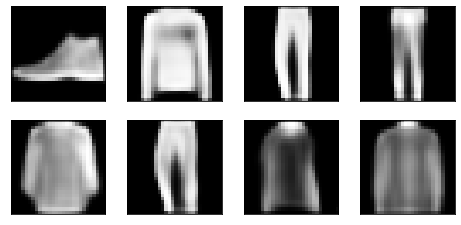

In [10]:
columns = 4
rows = 4
fig = plt.figure(figsize=(8, 8))
i = 1
for img in iter(test):
    if i <= 8:
        fig.add_subplot(rows, columns, i)
        out = exp.model(img[0])
        img = out[0,0,:,:]
        plt.imshow(img.detach().cpu().numpy(), cmap="gray")
        plt.xticks([])
        plt.yticks([])
    i += 1
plt.show()

<ipython-input-10-e2218ddae9d6>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out[:, :, x, j]).data


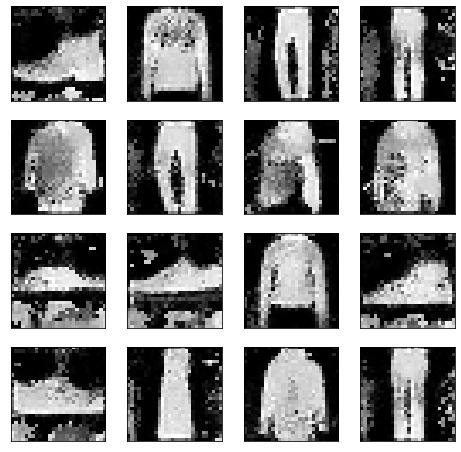

In [10]:
columns = 4
rows = 4
fig = plt.figure(figsize=(8, 8))
i = 1
for img in iter(test):
    if i <= 16:
        fig.add_subplot(rows, columns, i)
        out = exp.model(img[0])
        sample = torch.Tensor(28, 28).cuda()
        sample.fill_(0)
        for x in range(28):
            for j in range(28):
                probs = F.softmax(out[:, :, x, j]).data
                sample[x, j] = torch.multinomial(probs, 1).float() / 255.
        plt.imshow(sample.detach().cpu().numpy(), cmap="gray")
        plt.xticks([])
        plt.yticks([])
    i += 1
plt.show()

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

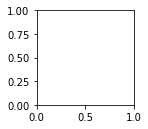

In [12]:
draw_likelihood_plot(exp.dataset.test_dataloader(), exp.model)